

# 🎯 Problema Resuelto: Problema del Viajante (TSP)
**Instancia:** 20 ciudades generadas aleatoriamente.
**Objetivo:** Minimizar la distancia total euclidiana en un ciclo cerrado.

## ⚙️ Análisis de la Implementación GA
El éxito de la implementación reside en la adaptación de la estructura continua de PyGAD a un problema de permutación.

### 1. Codificación y Fitness
| Aspecto | Implementación | Justificación Técnica |
| :--- | :--- | :--- |
| **Genotipo** | Vector continuo (`init_range_low=0`, `init_range_high=1`). | Permite el uso de operadores genéticos estándar de PyGAD. |
| **Decodificación** | `route = np.argsort(solution)` | **CRÍTICO:** Mapea el orden de los valores continuos a una secuencia discreta de índices, garantizando una permutación válida sin ciudades repetidas. |
| **Fitness Function** | `return -distance` | Transforma el objetivo de minimización (distancia) en maximización (requerido por PyGAD). |

### 2. Hiperparámetros Clave
| Parámetro | Valor | Rol en la Optimización |
| :--- | :--- | :--- |
| **num_genes** | 20 | Número de ciudades. |
| **sol_per_pop** | 50 | Diversidad de población suficiente para un buen muestreo del espacio. |
| **keep_parents** | 5 | **Elitismo:** Preserva las 5 mejores soluciones para asegurar la convergencia monótona. |
| **crossover_type** | `single_point` | Cruce simple para recombinar grandes segmentos del orden de la ruta. |
| **mutation_percent_genes** | 15 | Tasa de mutación moderada para evitar convergencia prematura. |

## 📈 Visualizaciones
El notebook genera un tablero con 6 paneles de análisis:
1.  **Curva de Convergencia:** Muestra cómo el mejor fitness (distancia) desciende y se estabiliza.
2.  **Métrica de Diversidad:** Monitoreo de `np.std(pop_fitness)` para asegurar que el algoritmo no se estanque (se observa una caída gradual).
3.  **Velocidad de Optimización:** Muestra la mejora de fitness por ventana de 10 generaciones.
4.  **Fenotipo (Ruta Óptima):** Visualización de la ruta final, con anotaciones para cada ciudad.
5.  **Relación Tiempo-Eficiencia:** Muestra el rendimiento computacional de la mejora.
6.  **Distribución de Fitness Final:** Confirma la concentración de la población en torno al óptimo local encontrado.

Problema TSP con 20 ciudades
Matriz de distancias calculada: (20, 20)

Iniciando optimización mediante Algoritmo Genético (GA)...
Generación 50: Mejor distancia = 550.81
Generación 100: Mejor distancia = 447.21
Generación 150: Mejor distancia = 421.32
Generación 200: Mejor distancia = 416.61
Generación 250: Mejor distancia = 416.61
Generación 300: Mejor distancia = 415.15
Generación 350: Mejor distancia = 415.15
Generación 400: Mejor distancia = 415.15
Generación 450: Mejor distancia = 415.15
Generación 500: Mejor distancia = 415.15

RESULTADOS FINALES - TSP MEDIANTE GA
Mejor distancia encontrada: 415.15
Mejor ruta (índices): [19 15 10 14 18  2  7  9 11  8 13  3  5 16  0 12  4 17  1  6]
Tiempo total: 0.81 segundos
Mejora respecto a ruta inicial: 47.50%


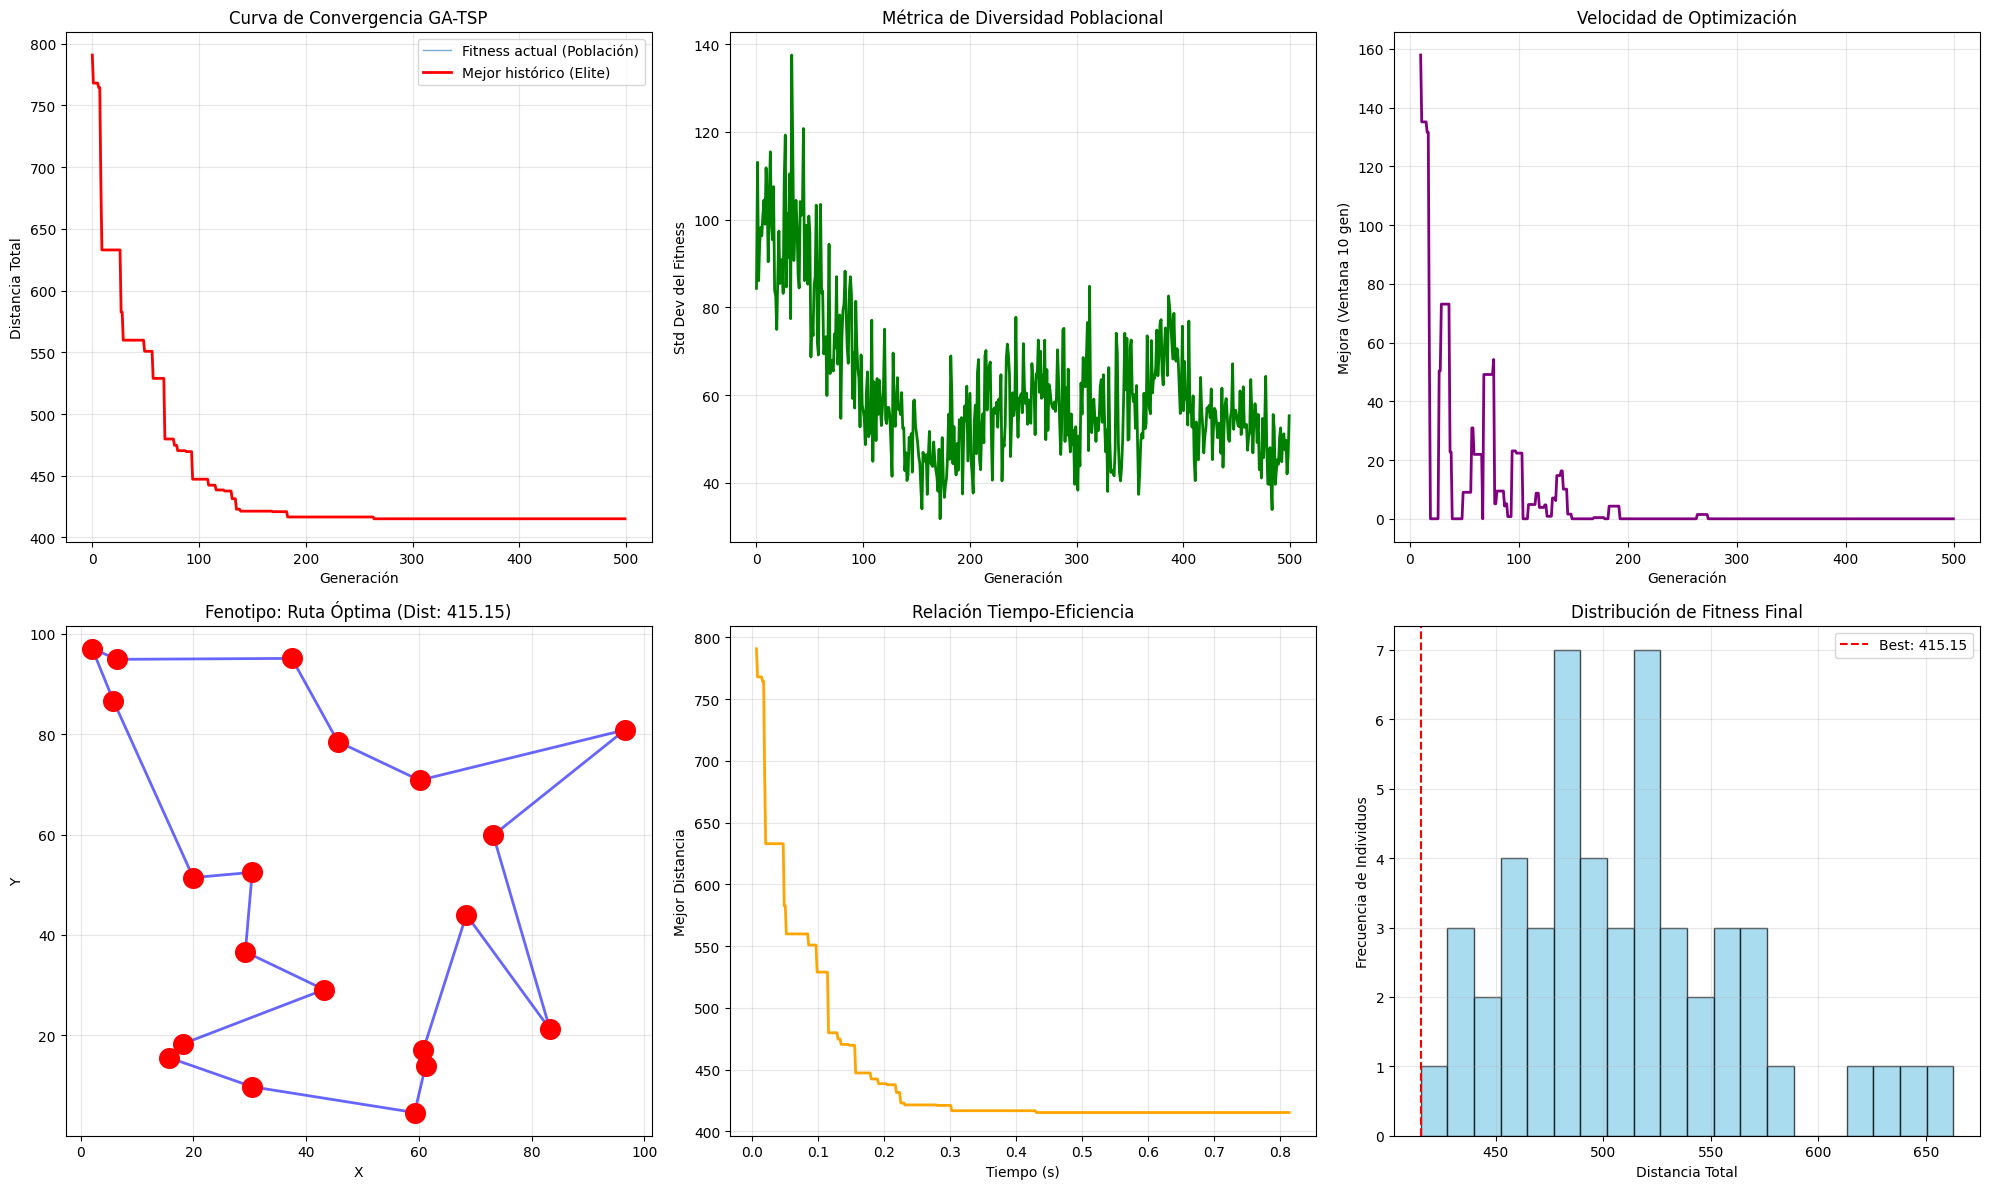

6

In [1]:
# ==============================================================================
# Transport Salesman Problem (VRP) resuelto con Algoritmos Genéticos usando PyGAD
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import pygad
from scipy.spatial import distance_matrix
import time

# ==============================================================================
# 1. CONFIGURACIÓN DEL PROBLEMA TSP
# ==============================================================================
np.random.seed(42)
num_cities = 20

# Generar coordenadas de ciudades aleatorias (0-100)
cities = np.random.rand(num_cities, 2) * 100

# Calcular matriz de distancias (Costo de viaje entre cualquier par de ciudades)
dist_matrix = distance_matrix(cities, cities)

print(f"Problema TSP con {num_cities} ciudades")
print(f"Matriz de distancias calculada: {dist_matrix.shape}")

# Variables para tracking del proceso evolutivo
fitness_history = []
best_fitness_history = []
diversity_history = []
time_history = []
start_time = time.time()

# ==============================================================================
# 2. FUNCIONES DE EVALUACIÓN (FITNESS)
# ==============================================================================

def calculate_route_distance(route, dist_matrix):
    """Calcula la distancia total de una ruta cerrada"""
    distance = 0
    for i in range(len(route) - 1):
        distance += dist_matrix[int(route[i]), int(route[i + 1])]
    # Retorno al punto de partida para cerrar el ciclo
    distance += dist_matrix[int(route[-1]), int(route[0])]
    return distance

def fitness_func(ga_instance, solution, solution_idx):
    """
    Función de fitness: PyGAD maximiza esta función.
    Mapeamos el espacio continuo a permutación usando argsort.
    """
    # El cromosoma continuo se convierte en una ruta de índices enteros
    route = np.argsort(solution)
    distance = calculate_route_distance(route, dist_matrix)
    
    # Devolvemos el negativo de la distancia porque PyGAD busca MAXIMIZAR
    return -distance 

def on_generation(ga_instance):
    """Callback para monitoreo de la evolución en cada generación"""
    solution, fitness, _ = ga_instance.best_solution()
    
    # Registro de la distancia real (positiva)
    fitness_history.append(-fitness)  
    
    if len(best_fitness_history) == 0:
        best_fitness_history.append(-fitness)
    else:
        best_fitness_history.append(min(best_fitness_history[-1], -fitness))
    
    # Diversidad: Medida a través de la desviación estándar del fitness de la población
    pop_fitness = ga_instance.last_generation_fitness
    diversity = np.std(pop_fitness)
    diversity_history.append(diversity)
    
    time_history.append(time.time() - start_time)
    
    if ga_instance.generations_completed % 50 == 0:
        print(f"Generación {ga_instance.generations_completed}: Mejor distancia = {-fitness:.2f}")

# ==============================================================================
# 3. CONFIGURACIÓN DEL MOTOR DE ALGORITMO GENÉTICO (PyGAD)
# ==============================================================================
# Nota: Se utiliza una representación continua que se decodifica a permutación.

num_generations = 500
sol_per_pop = 50

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=10,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_cities,
    init_range_low=0,
    init_range_high=1,
    parent_selection_type="tournament",
    K_tournament=3,
    keep_parents=5,
    crossover_type="single_point", # Operador de cruce genético
    mutation_type="random",       # Operador de mutación aleatoria
    mutation_percent_genes=15,
    on_generation=on_generation,
    suppress_warnings=True
)



print("\nIniciando optimización mediante Algoritmo Genético (GA)...")
ga_instance.run()

# ==============================================================================
# 4. EXTRACCIÓN DE RESULTADOS Y VISUALIZACIÓN
# ==============================================================================

solution, fitness, _ = ga_instance.best_solution()
best_route = np.argsort(solution)
best_distance = -fitness

print(f"\n{'='*60}")
print(f"RESULTADOS FINALES - TSP MEDIANTE GA")
print(f"{'='*60}")
print(f"Mejor distancia encontrada: {best_distance:.2f}")
print(f"Mejor ruta (índices): {best_route}")
print(f"Tiempo total: {time_history[-1]:.2f} segundos")
print(f"Mejora respecto a ruta inicial: {((fitness_history[0] - best_distance) / fitness_history[0] * 100):.2f}%")

# Generación del tablero de control de métricas
fig = plt.figure(figsize=(20, 12))

# 1. Gráfico de Convergencia
ax1 = plt.subplot(2, 3, 1)
ax1.plot(fitness_history, label='Fitness actual (Población)', alpha=0.6, linewidth=1)
ax1.plot(best_fitness_history, label='Mejor histórico (Elite)', linewidth=2, color='red')
ax1.set_xlabel('Generación')
ax1.set_ylabel('Distancia Total')
ax1.set_title('Curva de Convergencia GA-TSP')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Diversidad de la población (Evita el estancamiento)
ax2 = plt.subplot(2, 3, 2)
ax2.plot(diversity_history, color='green', linewidth=2)
ax2.set_xlabel('Generación')
ax2.set_ylabel('Std Dev del Fitness')
ax2.set_title('Métrica de Diversidad Poblacional')
ax2.grid(True, alpha=0.3)

# 3. Velocidad de mejora (Gradiente de optimización)
ax3 = plt.subplot(2, 3, 3)
improvements = []
window = 10
for i in range(window, len(best_fitness_history)):
    improvement = best_fitness_history[i-window] - best_fitness_history[i]
    improvements.append(improvement)
ax3.plot(range(window, len(best_fitness_history)), improvements, color='purple', linewidth=2)
ax3.set_xlabel('Generación')
ax3.set_ylabel('Mejora (Ventana 10 gen)')
ax3.set_title('Velocidad de Optimización')
ax3.grid(True, alpha=0.3)

# 4. Visualización Geográfica de la Ruta
ax4 = plt.subplot(2, 3, 4)
route_cities = np.append(best_route, best_route[0])
route_coords = cities[route_cities]
ax4.plot(route_coords[:, 0], route_coords[:, 1], 'b-', linewidth=2, alpha=0.6)
ax4.scatter(cities[:, 0], cities[:, 1], c='red', s=200, zorder=5)
for i, (x, y) in enumerate(cities):
    ax4.annotate(str(i), (x, y), fontsize=10, ha='center', va='center', color='white', weight='bold')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_title(f'Fenotipo: Ruta Óptima (Dist: {best_distance:.2f})')
ax4.grid(True, alpha=0.3)

# 5. Rendimiento Temporal
ax5 = plt.subplot(2, 3, 5)
ax5.plot(time_history, best_fitness_history, linewidth=2, color='orange')
ax5.set_xlabel('Tiempo (s)')
ax5.set_ylabel('Mejor Distancia')
ax5.set_title('Relación Tiempo-Eficiencia')
ax5.grid(True, alpha=0.3)

# 6. Estado Final de la Población
ax6 = plt.subplot(2, 3, 6)
final_pop_fitness = -ga_instance.last_generation_fitness
ax6.hist(final_pop_fitness, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax6.axvline(best_distance, color='red', linestyle='--', label=f'Best: {best_distance:.2f}')
ax6.set_xlabel('Distancia Total')
ax6.set_ylabel('Frecuencia de Individuos')
ax6.set_title('Distribución de Fitness Final')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsp_ga_results.png', dpi=300)
plt.show()

plt.close('all')
import gc
gc.collect()